# Kidney Condition Classification - Training Pipeline

This notebook implements the training pipeline for the dual-path kidney condition classification model.

## Model Architecture
- **Path A**: EfficientNet backbone (global features)
- **Path B**: Lightweight CNN (local features)
- **Fusion**: Cross-attention mechanism
- **Outputs**: Classification + Confidence heads

## Clinical Priorities
- **Tumor**: Maximize recall (catch all cases)
- **Stone**: Balance precision & recall
- **Cyst**: Balance precision & recall
- **Normal**: Prioritize precision (avoid false alarms)

In [1]:
import torch
torch.cuda.empty_cache()

In [2]:
import sys
from pathlib import Path
sys.path.append("/kaggle/input/renalfiles")

In [3]:
# Import required libraries
import sys
import os

import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Import project modules
from config import *
from models import DualPathKidneyClassifier, create_model
from loss import CombinedLoss, CombinedFocalLoss, create_loss_function
from training_pipeline import KidneyTrainer, create_trainer
from utils import (
    thresholded_predictions, compute_metrics, plot_confusion_matrix,
    plot_precision_recall_curves, evaluate_model_with_thresholds,
    SimpleLIMEWrapper, print_evaluation_report
)

from dataloader import create_datasets, create_dataloaders, analyze_dataset

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Set random seeds for reproducibility
torch.manual_seed(76)
np.random.seed(76)
if torch.cuda.is_available():
    torch.cuda.manual_seed(76)

Using device: cuda


In [4]:
print(f"Model: {MODEL_CONFIG['efficientnet_model']}")  # Should show 'efficientnet_b4'
print(f"Input size: {MODEL_CONFIG['input_size']}")     # Should show 380

Model: efficientnet_b4
Input size: 380


## 1. Dataset Loading and Analysis

In [5]:
# Define data directory path
# Update this path to point to your actual data directory
DATA_DIR = "/kaggle/input/ct-kidney-dataset-normal-cyst-tumor-and-stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/"

# Check if data directory exists
if not os.path.exists(DATA_DIR):
    print(f"Data directory not found: {DATA_DIR}")
    print("Please update DATA_DIR to point to your kidney dataset")
    print("Expected structure:")
    print("  CT-KIDNEY-DATASET-Normal/")
    print("  ├── CT-KIDNEY-DATASET-Normal/")
    print("  │   ├── Cyst/")
    print("  │   ├── Normal/")
    print("  │   ├── Stone/")
    print("  │   └── Tumor/")
    print("  └── kidneyData.csv")
else:
    # Analyze the dataset
    analyze_dataset(DATA_DIR)

Analyzing kidney ultrasound dataset...
Found class directories: ['Cyst', 'Normal', 'Stone', 'Tumor']
  Cyst: 3709 images
  Normal: 5077 images
  Stone: 1377 images
  Tumor: 2283 images

Total loaded: 12446 images from 4 classes

Dataset Statistics:
  Total images: 12446
  Number of classes: 4

Class Distribution:
  Cyst: 3709 (29.8%)
  Normal: 5077 (40.8%)
  Stone: 1377 (11.1%)
  Tumor: 2283 (18.3%)

Class Imbalance Ratio: 3.69
  Consider using weighted sampling or class weights.

All expected classes found: ['Cyst', 'Normal', 'Stone', 'Tumor']


In [6]:
# Create datasets if data directory exists
if os.path.exists(DATA_DIR):
    # Create datasets
    datasets = create_datasets(DATA_DIR)
    
    # Print dataset information
    for split_name, dataset in datasets.items():
        print(f"\n{split_name.upper()} Dataset:")
        print(f"  Size: {len(dataset)}")
        distribution = dataset.get_class_distribution()
        for class_name, count in distribution.items():
            print(f"  {class_name}: {count}")
    
    # Create dataloaders
    dataloaders = create_dataloaders(datasets, batch_size=TRAINING_CONFIG['batch_size'])
    
    print(f"\nDataloaders created with batch size: {TRAINING_CONFIG['batch_size']}")
else:
    print("Skipping dataset creation - data directory not found")
    datasets = None
    dataloaders = None

Found class directories: ['Cyst', 'Normal', 'Stone', 'Tumor']
  Cyst: 3709 images
  Normal: 5077 images
  Stone: 1377 images
  Tumor: 2283 images

Total loaded: 12446 images from 4 classes

Data splits:
  train: 8712 samples
    Cyst: 2597
    Normal: 3553
    Stone: 964
    Tumor: 1598
  val: 1867 samples
    Cyst: 556
    Normal: 762
    Stone: 206
    Tumor: 343
  test: 1867 samples
    Cyst: 556
    Normal: 762
    Stone: 207
    Tumor: 342

TRAIN Dataset:
  Size: 8712
  Cyst: 2597
  Normal: 3553
  Stone: 964
  Tumor: 1598

VAL Dataset:
  Size: 1867
  Cyst: 556
  Normal: 762
  Stone: 206
  Tumor: 343

TEST Dataset:
  Size: 1867
  Cyst: 556
  Normal: 762
  Stone: 207
  Tumor: 342

Dataloaders created with batch size: 16


## 2. Model Creation and Configuration

In [7]:
MODEL_CONFIG.update({'image_size' : MODEL_CONFIG['input_size']})
TRAINING_CONFIG.update({'scheduler_step_size': 10, 'scheduler_gamma': 0.5})

    
   

In [8]:
# Create model with freezing support
model = create_model()

print(f"Model created: {model.__class__.__name__}")
print(f"Total parameters: {sum(p.numel() for p in model.parameters()):,}")

# Apply dual-path optimized freezing
if FREEZING_CONFIG['enabled']:
    print(f"\n🧊 Applying dual-path freezing...")
    frozen_params, trainable_params = model.freeze_for_dual_path(
        freeze_stages=FREEZING_CONFIG['freeze_stages']
    )
    
    # Print freezing summary
    model.print_freezing_summary()
else:
    print("Freezing disabled in configuration")

# Move model to device
model = model.to(device)
print(f"Model moved to device: {device}")
model.to(device)

# Print model information
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Model created successfully!")
print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")

# Test forward pass
dummy_input = torch.randn(2, 3, MODEL_CONFIG['input_size'], MODEL_CONFIG['input_size']).to(device)
with torch.no_grad():
    logits, confidence = model(dummy_input)
    print(f"\nForward pass test:")
    print(f"  Input shape: {dummy_input.shape}")
    print(f"  Logits shape: {logits.shape}")
    print(f"  Confidence shape: {confidence.shape}")

model.safetensors:   0%|          | 0.00/77.9M [00:00<?, ?B/s]

Model created: DualPathKidneyClassifier
Total parameters: 19,711,309

🧊 Applying dual-path freezing...
❄️ Frozen EfficientNet stage 0
❄️ Frozen EfficientNet stage 1
❄️ Frozen EfficientNet stage 2
❄️ Frozen EfficientNet stage 3
🔥 Trainable EfficientNet stage 4
🔥 Trainable EfficientNet stage 5
🔥 Trainable EfficientNet stage 6

📊 EfficientNet Freezing Summary:
   Frozen: 1,329,260 parameters
   Trainable: 16,215,772 parameters
   Frozen ratio: 7.6%

🧊 Model Freezing Summary:
   Total parameters: 19,711,309
   Frozen parameters: 1,329,260 (6.7%)
   Trainable parameters: 18,382,049 (93.3%)

📋 Component Breakdown:
   EfficientNet: 1,329,260 frozen, 16,219,356 trainable
   Custom CNN: 520,960 trainable
   Other components: 1,641,733 trainable
Model moved to device: cuda
Model created successfully!
Total parameters: 19,711,309
Trainable parameters: 18,382,049

Forward pass test:
  Input shape: torch.Size([2, 3, 380, 380])
  Logits shape: torch.Size([2, 4])
  Confidence shape: torch.Size([2, 1]

## 3. Training Configuration

In [9]:
# Display training configuration
print("Training Configuration:")
for key, value in TRAINING_CONFIG.items():
    print(f"  {key}: {value}")

print("\nClass Weights:")
for class_name, weight in CLASS_WEIGHTS.items():
    print(f"  {class_name}: {weight}")

print("\nClass Thresholds:")
for class_name, threshold in CLASS_THRESHOLDS.items():
    print(f"  {class_name}: {threshold}")

print("\nClinical Priorities:")
for class_name, priority in CLINICAL_PRIORITIES.items():
    print(f"  {class_name}: {priority}")

Training Configuration:
  batch_size: 16
  learning_rate: 8e-05
  num_epochs: 50
  patience: 12
  min_delta: 0.001
  warmup_epochs: 5
  weight_decay: 0.0002
  gradient_clip_norm: 1.0
  scheduler_step_size: 10
  scheduler_gamma: 0.5

Class Weights:
  Cyst: 0.84
  Normal: 0.61
  Stone: 2.26
  Tumor: 1.36

Class Thresholds:
  Cyst: 0.5
  Normal: 0.6
  Stone: 0.5
  Tumor: 0.35

Clinical Priorities:
  Tumor: maximize_recall
  Stone: balance_precision_recall
  Cyst: balance_precision_recall
  Normal: prioritize_precision


## 4. Training Pipeline

In [10]:
# Create trainer if datasets are available
if datasets is not None:
    # Import KidneyTrainer directly since create_trainer might not exist
    from training_pipeline import KidneyTrainer
    
    # Create trainer with freezing support
    trainer = KidneyTrainer(
        model=model,
        train_loader=dataloaders['train'],
        val_loader=dataloaders['val'],
        device=device,
        loss_type='combined',  # or 'focal'
        save_dir='checkpoints',
        use_freezing=FREEZING_CONFIG['enabled']

    )
    
    print("Trainer created successfully!")
    print(f"Train batches: {len(trainer.train_loader)}")
    print(f"Validation batches: {len(trainer.val_loader)}")
else:
    print("Cannot create trainer - datasets not available")
    trainer = None

🧊 Applying dual-path optimized freezing...
❄️ Frozen EfficientNet stage 0
❄️ Frozen EfficientNet stage 1
❄️ Frozen EfficientNet stage 2
❄️ Frozen EfficientNet stage 3
🔥 Trainable EfficientNet stage 4
🔥 Trainable EfficientNet stage 5
🔥 Trainable EfficientNet stage 6

📊 EfficientNet Freezing Summary:
   Frozen: 1,329,260 parameters
   Trainable: 16,215,772 parameters
   Frozen ratio: 7.6%

🧊 Model Freezing Summary:
   Total parameters: 19,711,309
   Frozen parameters: 1,329,260 (6.7%)
   Trainable parameters: 18,382,049 (93.3%)

📋 Component Breakdown:
   EfficientNet: 1,329,260 frozen, 16,219,356 trainable
   Custom CNN: 520,960 trainable
   Other components: 1,641,733 trainable
Parameter groups created:
  efficientnet_trainable: 16,219,356 parameters, LR: 8.000000000000001e-06
  cnn: 520,960 parameters, LR: 8e-05
  other: 1,641,733 parameters, LR: 8e-05
Trainer created successfully!
Train batches: 544
Validation batches: 117


In [12]:
# Start training if trainer is available
if trainer is not None:
    print("Starting training...")
    print("This may take a while depending on your hardware and dataset size.")
    
    # Train the model
    history = trainer.train(num_epochs=TRAINING_CONFIG['num_epochs'])
    # history = trainer.train(num_epochs=3)
    
    print("\nTraining completed!")
else:
    print("Cannot start training - trainer not available")
    print("This is likely because the dataset was not found.")
    history = None

Starting training...
This may take a while depending on your hardware and dataset size.
Starting training for 50 epochs...
Device: cuda
Model parameters: 19,711,309
Batch 0/544, Loss: 1.4161, Acc: 31.25%
Batch 50/544, Loss: 1.2931, Acc: 48.04%
Batch 100/544, Loss: 1.2394, Acc: 58.11%
Batch 150/544, Loss: 0.8151, Acc: 60.31%
Batch 200/544, Loss: 0.7286, Acc: 61.32%
Batch 250/544, Loss: 0.6643, Acc: 62.90%
Batch 300/544, Loss: 0.7278, Acc: 64.06%
Batch 350/544, Loss: 0.7875, Acc: 65.35%
Batch 400/544, Loss: 0.1806, Acc: 66.79%
Batch 450/544, Loss: 0.2776, Acc: 67.84%
Batch 500/544, Loss: 0.2560, Acc: 69.06%

Epoch 1/50 (284.1s)
Train Loss: 0.8277, Train Acc: 0.6978
Val Loss: 0.4630, Val Acc: 0.8329, Val F1: 0.7989
Learning Rate: 0.000008
Saved best checkpoint with val F1: 0.7989
Batch 0/544, Loss: 1.0103, Acc: 68.75%
Batch 50/544, Loss: 0.5327, Acc: 79.29%
Batch 100/544, Loss: 0.2325, Acc: 81.68%
Batch 150/544, Loss: 0.4163, Acc: 81.21%
Batch 200/544, Loss: 0.3697, Acc: 82.06%
Batch 250/

## 5. Training Results Visualization

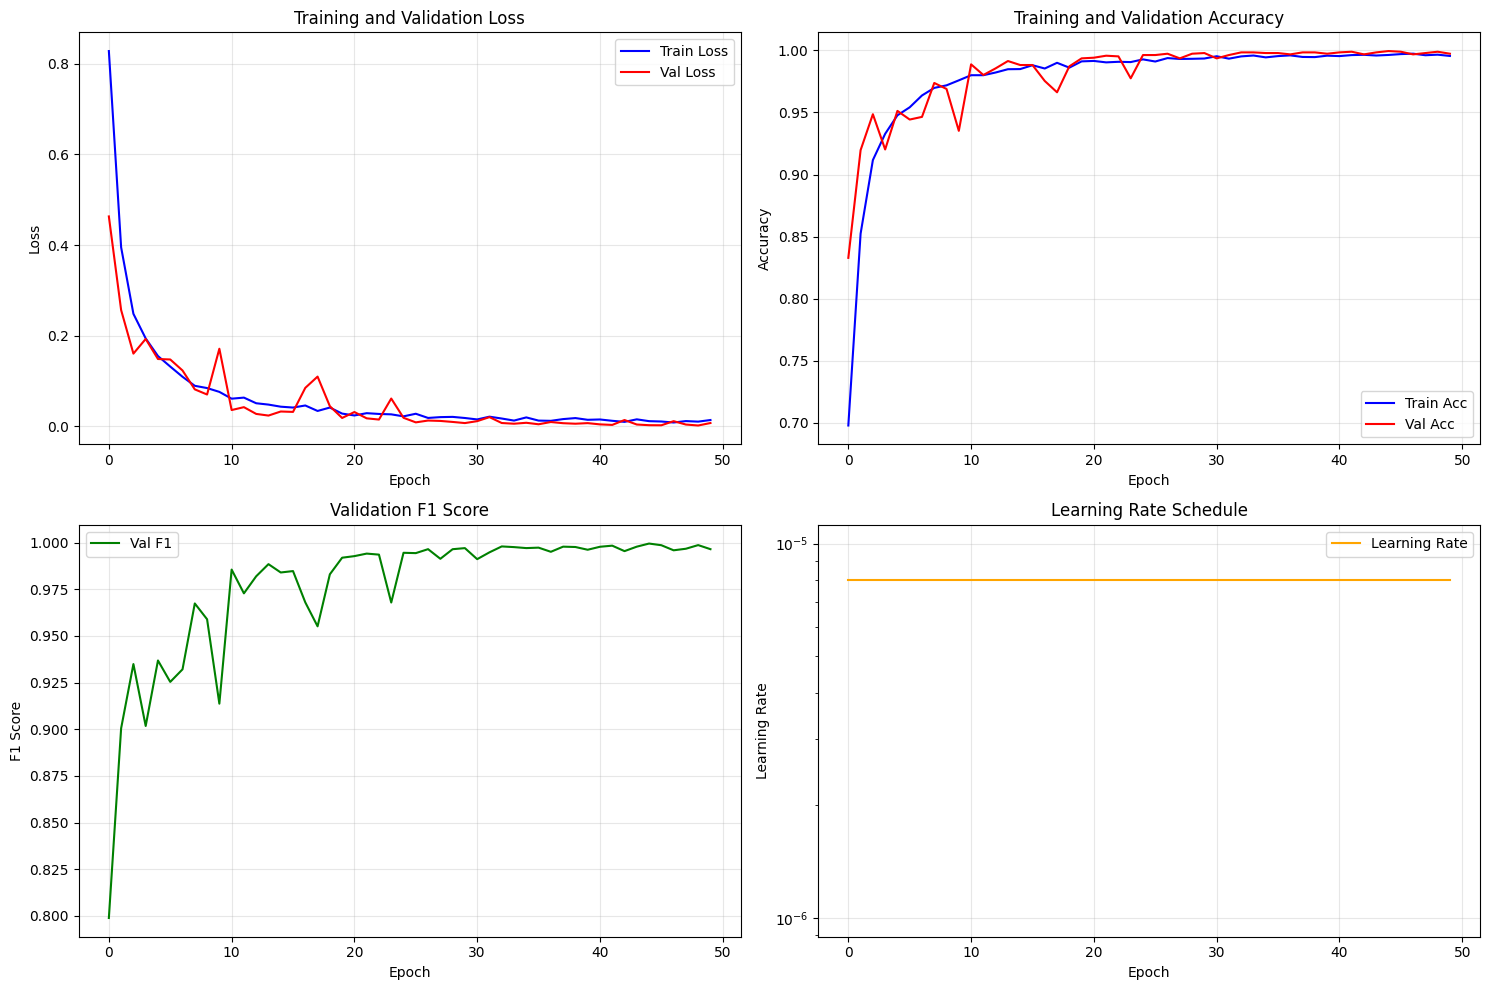


Final Training Metrics:
  Train Loss: 0.0140
  Train Accuracy: 0.9955
  Val Loss: 0.0074
  Val Accuracy: 0.9973
  Val F1: 0.9965

Best Performance:
  Best Epoch: 45
  Best Val F1: 0.9995


In [13]:
# Plot training history if available
if history is not None:
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # Loss plot
    axes[0, 0].plot(history['train_loss'], label='Train Loss', color='blue')
    axes[0, 0].plot(history['val_loss'], label='Val Loss', color='red')
    axes[0, 0].set_title('Training and Validation Loss')
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Loss')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    
    # Accuracy plot
    axes[0, 1].plot(history['train_acc'], label='Train Acc', color='blue')
    axes[0, 1].plot(history['val_acc'], label='Val Acc', color='red')
    axes[0, 1].set_title('Training and Validation Accuracy')
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('Accuracy')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
    
    # F1 Score plot
    axes[1, 0].plot(history['val_f1'], label='Val F1', color='green')
    axes[1, 0].set_title('Validation F1 Score')
    axes[1, 0].set_xlabel('Epoch')
    axes[1, 0].set_ylabel('F1 Score')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)
    
    # Learning rate plot
    axes[1, 1].plot(history['learning_rate'], label='Learning Rate', color='orange')
    axes[1, 1].set_title('Learning Rate Schedule')
    axes[1, 1].set_xlabel('Epoch')
    axes[1, 1].set_ylabel('Learning Rate')
    axes[1, 1].set_yscale('log')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Print final metrics
    print(f"\nFinal Training Metrics:")
    print(f"  Train Loss: {history['train_loss'][-1]:.4f}")
    print(f"  Train Accuracy: {history['train_acc'][-1]:.4f}")
    print(f"  Val Loss: {history['val_loss'][-1]:.4f}")
    print(f"  Val Accuracy: {history['val_acc'][-1]:.4f}")
    print(f"  Val F1: {history['val_f1'][-1]:.4f}")
    
    # Best epoch
    best_epoch = np.argmax(history['val_f1']) + 1
    best_f1 = max(history['val_f1'])
    print(f"\nBest Performance:")
    print(f"  Best Epoch: {best_epoch}")
    print(f"  Best Val F1: {best_f1:.4f}")
else:
    print("No training history available to plot.")

## 6. Model Saving

In [14]:
# Save the final model if training was completed
if trainer is not None and history is not None:
    # Create models directory if it doesn't exist
    models_dir = Path("models")
    models_dir.mkdir(exist_ok=True)
    
    # Save the final model
    final_model_path = models_dir / "kidney_classifier_final.pth"
    torch.save({
        'model_state_dict': trainer.model.state_dict(),
        'model_config': MODEL_CONFIG,
        'class_names': CLASS_NAMES,
        'class_weights': CLASS_WEIGHTS,
        'class_thresholds': CLASS_THRESHOLDS,
        'training_history': history,
        'final_metrics': {
            'val_f1': history['val_f1'][-1],
            'val_acc': history['val_acc'][-1],
            'val_loss': history['val_loss'][-1]
        }
    }, final_model_path)
    
    print(f"Final model saved to: {final_model_path}")
    print("\nModel can be loaded for evaluation using:")
    print(f"  checkpoint = torch.load('{final_model_path}')")
    print(f"  model.load_state_dict(checkpoint['model_state_dict'])")
else:
    print("No trained model to save.")

Final model saved to: models/kidney_classifier_final.pth

Model can be loaded for evaluation using:
  checkpoint = torch.load('models/kidney_classifier_final.pth')
  model.load_state_dict(checkpoint['model_state_dict'])


## 7. Summary

In [15]:
print("=" * 60)
print("TRAINING PIPELINE SUMMARY")
print("=" * 60)

print(f"\nModel Architecture:")
print(f"  - Dual-path design with EfficientNet + lightweight CNN")
print(f"  - Cross-attention fusion mechanism")
print(f"  - Classification + confidence heads")
print(f"  - Total parameters: {total_params:,}")

print(f"\nDataset:")
if datasets is not None:
    total_samples = sum(len(dataset) for dataset in datasets.values())
    print(f"  - Total samples: {total_samples}")
    print(f"  - Train: {len(datasets['train'])}")
    print(f"  - Validation: {len(datasets['val'])}")
    print(f"  - Test: {len(datasets['test'])}")
else:
    print(f"  - Dataset not loaded (check data directory path)")

print(f"\nTraining Configuration:")
print(f"  - Epochs: {TRAINING_CONFIG['num_epochs']}")
print(f"  - Batch size: {TRAINING_CONFIG['batch_size']}")
print(f"  - Learning rate: {TRAINING_CONFIG['learning_rate']}")
print(f"  - Device: {device}")

if history is not None:
    print(f"\nTraining Results:")
    print(f"  - Final validation F1: {history['val_f1'][-1]:.4f}")
    print(f"  - Final validation accuracy: {history['val_acc'][-1]:.4f}")
    print(f"  - Best validation F1: {max(history['val_f1']):.4f}")
    print(f"  - Best epoch: {np.argmax(history['val_f1']) + 1}")

print(f"\nNext Steps:")
print(f"  1. Run evaluation.ipynb for detailed model assessment")
print(f"  2. Analyze per-class performance and clinical relevance")
print(f"  3. Generate LIME explanations for interpretability")
print(f"  4. Fine-tune thresholds based on clinical priorities")

print("\n" + "=" * 60)

TRAINING PIPELINE SUMMARY

Model Architecture:
  - Dual-path design with EfficientNet + lightweight CNN
  - Cross-attention fusion mechanism
  - Classification + confidence heads
  - Total parameters: 19,711,309

Dataset:
  - Total samples: 12446
  - Train: 8712
  - Validation: 1867
  - Test: 1867

Training Configuration:
  - Epochs: 50
  - Batch size: 16
  - Learning rate: 8e-05
  - Device: cuda

Training Results:
  - Final validation F1: 0.9965
  - Final validation accuracy: 0.9973
  - Best validation F1: 0.9995
  - Best epoch: 45

Next Steps:
  1. Run evaluation.ipynb for detailed model assessment
  2. Analyze per-class performance and clinical relevance
  3. Generate LIME explanations for interpretability
  4. Fine-tune thresholds based on clinical priorities




# Evaluation Components
1. **Threshold-aware predictions** using clinical priorities
2. **Comprehensive metrics** (precision, recall, F1, ROC-AUC)
3. **Confusion matrix** analysis
4. **Precision-Recall curves** per class
5. **LIME explanations** for interpretability
6. **Clinical relevance** assessment
7. 

In [16]:
import warnings
warnings.filterwarnings('ignore')

# Set style for better plots
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

## 8. Load Trained Model


In [17]:
# Define model path
MODEL_PATH = "models/kidney_classifier_final.pth"  # or "../checkpoints/best_checkpoint.pth"

# Check if model exists
if not os.path.exists(MODEL_PATH):
    print(f"Model not found at: {MODEL_PATH}")
    print("Please ensure you have trained the model first using training.ipynb")
    print("Alternative paths to check:")
    print("  - checkpoints/best_checkpoint.pth")
    print("  - checkpoints/latest_checkpoint.pth")
    model_loaded = False
else:
    # Load the trained model
    print(f"Loading model from: {MODEL_PATH}")
    
    # Create model
    model = create_model()
    
    # Load checkpoint
    checkpoint = torch.load(MODEL_PATH, map_location=device, weights_only=False)
    model.load_state_dict(checkpoint['model_state_dict'])
    model.to(device)
    model.eval()
    
    print("Model loaded successfully!")
    
    # Print model info from checkpoint
    if 'final_metrics' in checkpoint:
        metrics = checkpoint['final_metrics']
        print(f"\nModel Performance (from training):")
        print(f"  Validation F1: {metrics.get('val_f1', 'N/A')}")
        print(f"  Validation Accuracy: {metrics.get('val_acc', 'N/A')}")
        print(f"  Validation Loss: {metrics.get('val_loss', 'N/A')}")
    
    model_loaded = True

Loading model from: models/kidney_classifier_final.pth
Model loaded successfully!

Model Performance (from training):
  Validation F1: 0.9964612268452071
  Validation Accuracy: 0.9973219068023568
  Validation Loss: 0.007427787878870205


## 9. Load Test Dataset

In [18]:
# Load datasets
if os.path.exists(DATA_DIR) and model_loaded:
    datasets = create_datasets(DATA_DIR)
    dataloaders = create_dataloaders(datasets, batch_size=32)
    
    # Get test dataset info
    test_dataset = datasets['test']
    test_loader = dataloaders['test']
    
    print(f"Test dataset loaded:")
    print(f"  Total samples: {len(test_dataset)}")
    
    # Print test set distribution
    distribution = test_dataset.get_class_distribution()
    print(f"\nTest set class distribution:")
    for class_name, count in distribution.items():
        percentage = 100 * count / len(test_dataset)
        print(f"  {class_name}: {count} ({percentage:.1f}%)")
    
    datasets_loaded = True
else:
    print("Cannot load datasets - either data directory not found or model not loaded")
    datasets_loaded = False

Found class directories: ['Cyst', 'Normal', 'Stone', 'Tumor']
  Cyst: 3709 images
  Normal: 5077 images
  Stone: 1377 images
  Tumor: 2283 images

Total loaded: 12446 images from 4 classes

Data splits:
  train: 8712 samples
    Cyst: 2597
    Normal: 3553
    Stone: 964
    Tumor: 1598
  val: 1867 samples
    Cyst: 556
    Normal: 762
    Stone: 206
    Tumor: 343
  test: 1867 samples
    Cyst: 556
    Normal: 762
    Stone: 207
    Tumor: 342
Test dataset loaded:
  Total samples: 1867

Test set class distribution:
  Cyst: 556 (29.8%)
  Normal: 762 (40.8%)
  Stone: 207 (11.1%)
  Tumor: 342 (18.3%)


## 10. Model Evaluation with Threshold-Aware Predictions

In [19]:
# Evaluate model if both model and datasets are loaded
if model_loaded and datasets_loaded:
    print("Evaluating model with threshold-aware predictions...")
    print(f"Using thresholds: {CLASS_THRESHOLDS}")
    
    # Run evaluation
    results = evaluate_model_with_thresholds(model, test_loader, device)
    
    # Extract results
    y_true = results['targets']
    y_pred = results['predictions']
    y_probs = results['probabilities']
    confidences = results['confidences']
    
    print(f"\nEvaluation completed!")
    print(f"  Test samples: {len(y_true)}")
    print(f"  Predictions shape: {y_pred.shape}")
    print(f"  Probabilities shape: {y_probs.shape}")
    print(f"  Confidences shape: {confidences.shape}")
    
    evaluation_completed = True
else:
    print("Cannot evaluate model - missing model or datasets")
    evaluation_completed = False

Evaluating model with threshold-aware predictions...
Using thresholds: {'Cyst': 0.5, 'Normal': 0.6, 'Stone': 0.5, 'Tumor': 0.35}

Evaluation completed!
  Test samples: 1867
  Predictions shape: (1867,)
  Probabilities shape: (1867, 4)
  Confidences shape: (1867, 1)


## 11. Comprehensive Metrics Analysis

In [20]:
# Compute and display comprehensive metrics
if evaluation_completed:
    # Compute metrics
    metrics = compute_metrics(y_true, y_pred, y_probs, CLASS_NAMES)
    
    # Print detailed evaluation report
    print_evaluation_report(metrics)
    
    # Store metrics for later use
    eval_metrics = metrics
else:
    print("Cannot compute metrics - evaluation not completed")

KIDNEY CONDITION CLASSIFICATION - EVALUATION REPORT

Overall Metrics:
  Accuracy: 0.9973
  Macro F1: 0.9971
  Macro Precision: 0.9964
  Macro Recall: 0.9978
  Macro ROC-AUC: 1.0000

Per-Class Metrics:
Class      Precision  Recall     F1         Support   
--------------------------------------------------
Cyst       1.0000     0.9910     0.9955     556       
Normal     1.0000     1.0000     1.0000     762       
Stone      1.0000     1.0000     1.0000     207       
Tumor      0.9856     1.0000     0.9927     342       

Clinical Priority Assessment:
  Cyst: Balanced Precision & Recall
    - Recall: 0.9910
    - Precision: 1.0000
  Normal: High Precision (avoid false alarms)
    - Recall: 1.0000
    - Precision: 1.0000
  Stone: Balanced Precision & Recall
    - Recall: 1.0000
    - Precision: 1.0000
  Tumor: High Recall (catch all tumors)
    - Recall: 1.0000
    - Precision: 0.9856


## 12. Confusion Matrix Visualization

<Figure size 1000x800 with 0 Axes>

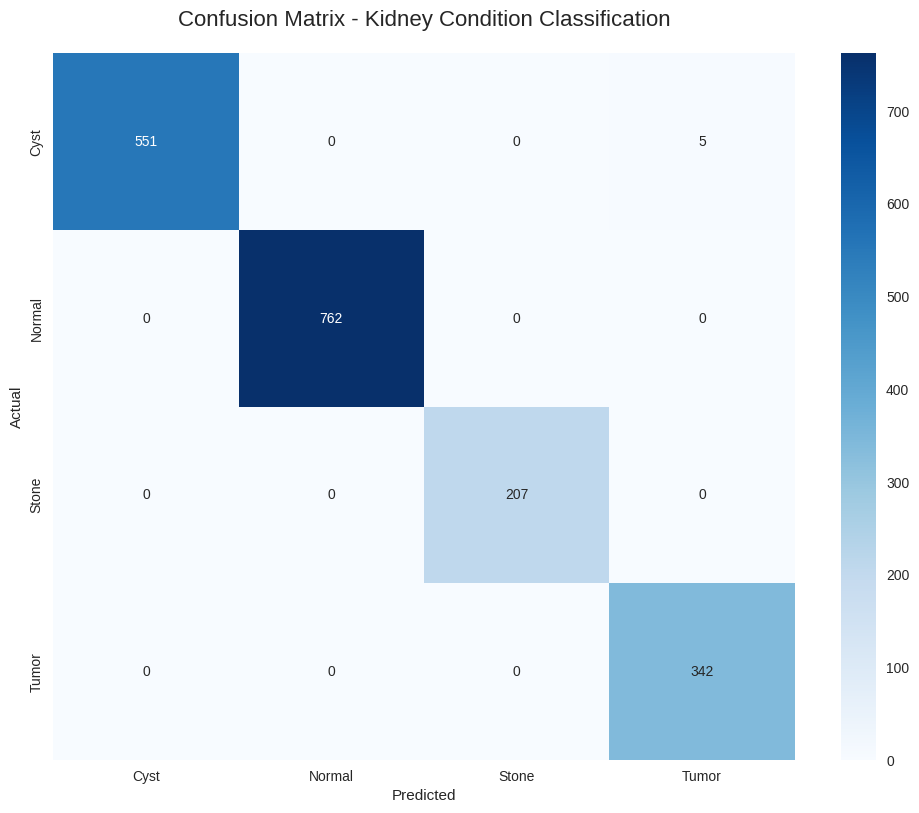


Confusion Matrix Analysis:

Cyst:
  Correct predictions: 551/556 (99.1%)
  Misclassified as Tumor: 5

Normal:
  Correct predictions: 762/762 (100.0%)

Stone:
  Correct predictions: 207/207 (100.0%)

Tumor:
  Correct predictions: 342/342 (100.0%)


In [21]:
# Plot confusion matrix
if evaluation_completed:
    plt.figure(figsize=(10, 8))
    plot_confusion_matrix(y_true, y_pred, CLASS_NAMES, figsize=(10, 8))
    plt.title('Confusion Matrix - Kidney Condition Classification', fontsize=16, pad=20)
    plt.show()
    
    # Analyze confusion matrix
    from sklearn.metrics import confusion_matrix
    cm = confusion_matrix(y_true, y_pred)
    
    print("\nConfusion Matrix Analysis:")
    for i, class_name in enumerate(CLASS_NAMES):
        total_actual = cm[i].sum()
        correct = cm[i, i]
        accuracy = correct / total_actual if total_actual > 0 else 0
        
        print(f"\n{class_name}:")
        print(f"  Correct predictions: {correct}/{total_actual} ({100*accuracy:.1f}%)")
        
        # Misclassifications
        for j, other_class in enumerate(CLASS_NAMES):
            if i != j and cm[i, j] > 0:
                print(f"  Misclassified as {other_class}: {cm[i, j]}")
else:
    print("Cannot plot confusion matrix - evaluation not completed")

## 13. Precision-Recall Curves

<Figure size 1200x800 with 0 Axes>

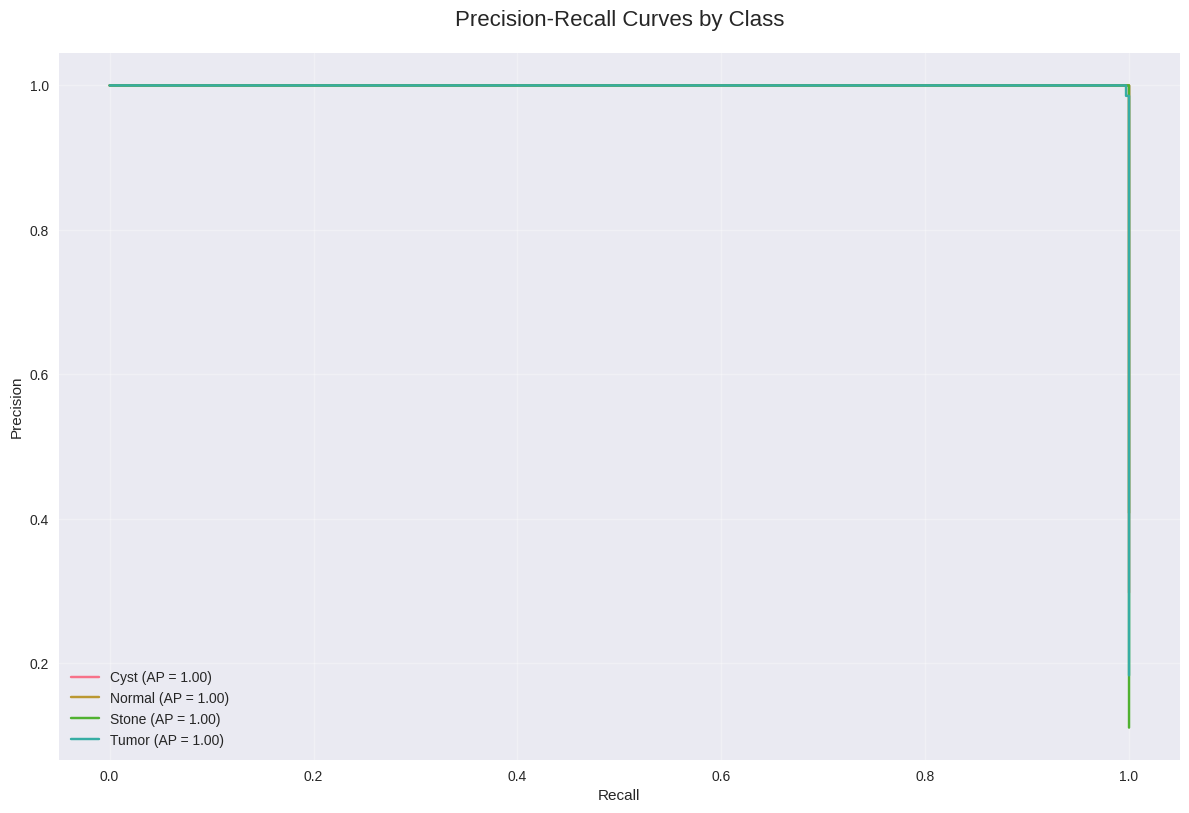


Average Precision (AP) Scores:
  Cyst: 1.000 (Priority: balance_precision_recall)
  Normal: 1.000 (Priority: prioritize_precision)
  Stone: 1.000 (Priority: balance_precision_recall)
  Tumor: 1.000 (Priority: maximize_recall)

Mean Average Precision (mAP): 1.000


In [22]:
# Plot precision-recall curves
if evaluation_completed:
    plt.figure(figsize=(12, 8))
    plot_precision_recall_curves(y_true, y_probs, CLASS_NAMES, figsize=(12, 8))
    plt.title('Precision-Recall Curves by Class', fontsize=16, pad=20)
    plt.show()
    
    # Calculate and display average precision scores
    from sklearn.metrics import average_precision_score
    from sklearn.preprocessing import label_binarize
    
    y_true_bin = label_binarize(y_true, classes=range(len(CLASS_NAMES)))
    
    print("\nAverage Precision (AP) Scores:")
    ap_scores = []
    for i, class_name in enumerate(CLASS_NAMES):
        ap = average_precision_score(y_true_bin[:, i], y_probs[:, i])
        ap_scores.append(ap)
        priority = CLINICAL_PRIORITIES[class_name]
        print(f"  {class_name}: {ap:.3f} (Priority: {priority})")
    
    print(f"\nMean Average Precision (mAP): {np.mean(ap_scores):.3f}")
else:
    print("Cannot plot PR curves - evaluation not completed")

## 14. Confidence Analysis

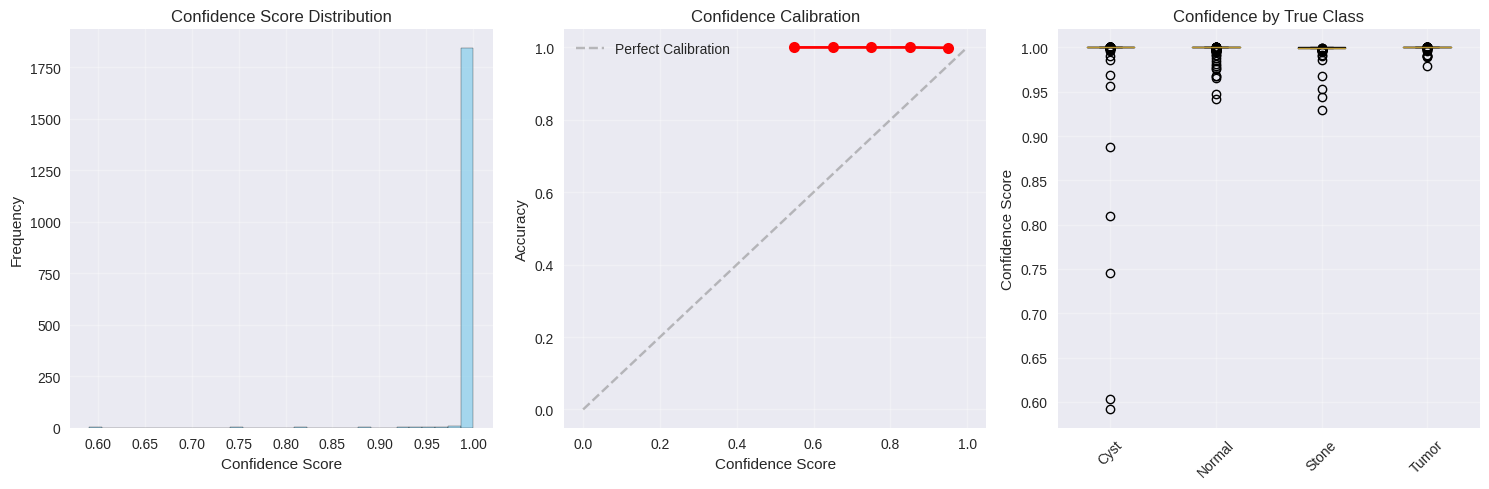


Confidence Statistics:
  Mean confidence: 0.999
  Std confidence: 0.016
  Min confidence: 0.591
  Max confidence: 1.000

Confidence by Prediction Correctness:
  Correct predictions - mean confidence: 0.999
  Incorrect predictions - mean confidence: 1.000


In [23]:
# Analyze confidence predictions
if evaluation_completed:
    # Calculate accuracy for different confidence ranges
    correct_predictions = (y_pred == y_true)
    
    # Flatten confidences to 1D array if needed
    confidences_flat = confidences.flatten() if confidences.ndim > 1 else confidences
    
    plt.figure(figsize=(15, 5))
    
    # Confidence distribution
    plt.subplot(1, 3, 1)
    plt.hist(confidences_flat, bins=30, alpha=0.7, color='skyblue', edgecolor='black')
    plt.xlabel('Confidence Score')
    plt.ylabel('Frequency')
    plt.title('Confidence Score Distribution')
    plt.grid(True, alpha=0.3)
    
    # Confidence vs Accuracy
    plt.subplot(1, 3, 2)
    conf_bins = np.linspace(0, 1, 11)
    accuracies = []
    bin_centers = []
    
    for i in range(len(conf_bins) - 1):
        mask = (confidences_flat >= conf_bins[i]) & (confidences_flat < conf_bins[i + 1])
        if mask.sum() > 0:
            acc = correct_predictions[mask].mean()
            accuracies.append(acc)
            bin_centers.append((conf_bins[i] + conf_bins[i + 1]) / 2)
    
    plt.plot(bin_centers, accuracies, 'o-', color='red', linewidth=2, markersize=8)
    plt.plot([0, 1], [0, 1], '--', color='gray', alpha=0.5, label='Perfect Calibration')
    plt.xlabel('Confidence Score')
    plt.ylabel('Accuracy')
    plt.title('Confidence Calibration')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Confidence by class
    plt.subplot(1, 3, 3)
    conf_by_class = [confidences_flat[y_true == i] for i in range(len(CLASS_NAMES))]
    plt.boxplot(conf_by_class, labels=CLASS_NAMES)
    plt.ylabel('Confidence Score')
    plt.title('Confidence by True Class')
    plt.xticks(rotation=45)
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Print confidence statistics
    print(f"\nConfidence Statistics:")
    print(f"  Mean confidence: {confidences_flat.mean():.3f}")
    print(f"  Std confidence: {confidences_flat.std():.3f}")
    print(f"  Min confidence: {confidences_flat.min():.3f}")
    print(f"  Max confidence: {confidences_flat.max():.3f}")
    
    # Confidence for correct vs incorrect predictions
    correct_conf = confidences_flat[correct_predictions]
    incorrect_conf = confidences_flat[~correct_predictions]
    
    print(f"\nConfidence by Prediction Correctness:")
    print(f"  Correct predictions - mean confidence: {correct_conf.mean():.3f}")
    print(f"  Incorrect predictions - mean confidence: {incorrect_conf.mean():.3f}")
else:
    print("Cannot analyze confidence - evaluation not completed")

## 15. Clinical Priority Assessment

In [24]:
# Assess performance against clinical priorities
if evaluation_completed:
    print("=" * 60)
    print("CLINICAL PRIORITY ASSESSMENT")
    print("=" * 60)
    
    for class_name in CLASS_NAMES:
        class_idx = CLASS_NAMES.index(class_name)
        metrics_class = eval_metrics['per_class_metrics'][class_name]
        
        precision = metrics_class['precision']
        recall = metrics_class['recall']
        f1 = metrics_class['f1']
        support = metrics_class['support']
        threshold = CLASS_THRESHOLDS[class_name]
        priority = CLINICAL_PRIORITIES[class_name]
        
        print(f"\n{class_name.upper()} (Threshold: {threshold})")
        print(f"  Clinical Priority: {priority}")
        print(f"  Support: {support} samples")
        print(f"  Precision: {precision:.3f}")
        print(f"  Recall: {recall:.3f}")
        print(f"  F1-Score: {f1:.3f}")
        
        # Clinical assessment
        if class_name == 'Tumor':
            if recall >= 0.90:
                assessment = "EXCELLENT - High recall achieved"
            elif recall >= 0.80:
                assessment = "GOOD - Acceptable recall"
            else:
                assessment = "NEEDS IMPROVEMENT - Low recall for critical condition"
                
        elif class_name == 'Normal':
            if precision >= 0.90:
                assessment = "EXCELLENT - High precision achieved"
            elif precision >= 0.80:
                assessment = "GOOD - Acceptable precision"
            else:
                assessment = "NEEDS IMPROVEMENT - Too many false alarms"
                
        else:  # Stone, Cyst
            avg_pr = (precision + recall) / 2
            if avg_pr >= 0.85:
                assessment = "EXCELLENT - Well-balanced performance"
            elif avg_pr >= 0.75:
                assessment = "GOOD - Acceptable balance"
            else:
                assessment = "NEEDS IMPROVEMENT - Unbalanced performance"
        
        print(f"  Clinical Assessment: {assessment}")
    
    print("\n" + "=" * 60)
else:
    print("Cannot assess clinical priorities - evaluation not completed")

CLINICAL PRIORITY ASSESSMENT

CYST (Threshold: 0.5)
  Clinical Priority: balance_precision_recall
  Support: 556 samples
  Precision: 1.000
  Recall: 0.991
  F1-Score: 0.995
  Clinical Assessment: EXCELLENT - Well-balanced performance

NORMAL (Threshold: 0.6)
  Clinical Priority: prioritize_precision
  Support: 762 samples
  Precision: 1.000
  Recall: 1.000
  F1-Score: 1.000
  Clinical Assessment: EXCELLENT - High precision achieved

STONE (Threshold: 0.5)
  Clinical Priority: balance_precision_recall
  Support: 207 samples
  Precision: 1.000
  Recall: 1.000
  F1-Score: 1.000
  Clinical Assessment: EXCELLENT - Well-balanced performance

TUMOR (Threshold: 0.35)
  Clinical Priority: maximize_recall
  Support: 342 samples
  Precision: 0.986
  Recall: 1.000
  F1-Score: 0.993
  Clinical Assessment: EXCELLENT - High recall achieved



## 16. LIME Explanations 

In [ ]:
from lime import lime_image
from skimage.segmentation import mark_boundaries
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn.functional as F
from PIL import Image
import cv2



class FullLIMEExplainer:
    """
    Complete LIME implementation for kidney condition classification
    """
    
    def __init__(self, model, device='cpu', class_names=None):
        self.model = model
        self.device = device
        self.class_names = class_names or CLASS_NAMES
        self.model.eval()
        
        # Initialize LIME image explainer
        self.explainer = lime_image.LimeImageExplainer()
    
    def predict_fn(self, images):
        """
        Prediction function for LIME
        
        Args:
            images: numpy array of images [batch_size, height, width, channels]
            
        Returns:
            probabilities: numpy array of predictions [batch_size, num_classes]
        """
        # Convert numpy images to torch tensors
        if len(images.shape) == 4:  # Batch of images
            # Convert from [B, H, W, C] to [B, C, H, W]
            images_tensor = torch.tensor(images, dtype=torch.float32).permute(0, 3, 1, 2)
        else:  # Single image
            # Convert from [H, W, C] to [1, C, H, W]
            images_tensor = torch.tensor(images, dtype=torch.float32).permute(2, 0, 1).unsqueeze(0)
        
        # Normalize to [0, 1] if needed
        if images_tensor.max() > 1.0:
            images_tensor = images_tensor / 255.0
        
        images_tensor = images_tensor.to(self.device)
        
        with torch.no_grad():
            logits, _ = self.model(images_tensor)
            probabilities = F.softmax(logits, dim=1)
            
        return probabilities.cpu().numpy()
    
    def explain_instance(self, image, top_labels=None, num_samples=1000, num_features=100000):
        """
        Generate LIME explanation for a single image
        
        Args:
            image: PIL Image or numpy array
            top_labels: Number of top labels to explain (default: all classes)
            num_samples: Number of samples for LIME
            num_features: Number of features for explanation
            
        Returns:
            explanation: LIME explanation object
        """
        # Convert image to numpy array if needed
        if isinstance(image, torch.Tensor):
            if image.dim() == 4:  # Remove batch dimension if present
                image = image.squeeze(0)
            # Convert from [C, H, W] to [H, W, C]
            image_np = image.permute(1, 2, 0).cpu().numpy()
        elif isinstance(image, Image.Image):
            image_np = np.array(image)
        else:
            image_np = image
        
        # Ensure image is in [0, 255] range for LIME
        if image_np.max() <= 1.0:
            image_np = (image_np * 255).astype(np.uint8)
        else:
            image_np = image_np.astype(np.uint8)
        
        # Generate explanation
        explanation = self.explainer.explain_instance(
            image_np,
            self.predict_fn,
            top_labels=top_labels,
            hide_color=0,
            num_samples=num_samples,
            num_features=num_features
        )
        
        return explanation
    
    def visualize_explanation(self, explanation, image, label_idx, positive_only=True, 
                            hide_rest=False, figsize=(12, 8)):
        """
        Visualize LIME explanation
        
        Args:
            explanation: LIME explanation object
            image: Original image
            label_idx: Index of class to explain
            positive_only: Show only positive features
            hide_rest: Hide non-contributing regions
            figsize: Figure size for plotting
        """
        # Get image and mask
        temp_img, mask = explanation.get_image_and_mask(
            label_idx, 
            positive_only=positive_only, 
            hide_rest=hide_rest
        )
        
        # Create visualization
        fig, axes = plt.subplots(1, 3, figsize=figsize)
        
        # Original image
        if isinstance(image, torch.Tensor):
            if image.dim() == 4:
                image = image.squeeze(0)
            img_display = image.permute(1, 2, 0).cpu().numpy()
        else:
            img_display = image
            
        if img_display.max() <= 1.0:
            img_display = (img_display * 255).astype(np.uint8)
        
        axes[0].imshow(img_display)
        axes[0].set_title('Original Image')
        axes[0].axis('off')
        
        # Explanation heatmap
        axes[1].imshow(temp_img)
        axes[1].set_title(f'LIME Explanation\n{self.class_names[label_idx]}')
        axes[1].axis('off')
        
        # Boundary visualization
        boundary_img = mark_boundaries(temp_img, mask)
        axes[2].imshow(boundary_img)
        axes[2].set_title('Feature Boundaries')
        axes[2].axis('off')
        
        plt.tight_layout()
        return fig
    
    def get_explanation_summary(self, explanation, top_k=5):
        """
        Get summary of explanation with top predictions and confidence scores
        
        Args:
            explanation: LIME explanation object
            top_k: Number of top predictions to return
            
        Returns:
            summary: Dictionary with prediction details
        """
        # Get available labels from explanation
        available_labels = explanation.available_labels[:top_k]
        
        predictions = []
        for label in available_labels:
            prob = explanation.predict_proba[label]
            predictions.append({
                'class': self.class_names[label],
                'probability': prob,
                'index': label
            })
        
        # Sort by probability
        predictions.sort(key=lambda x: x['probability'], reverse=True)
        
        return {
            'top_predictions': predictions,
            'predicted_class': predictions[0]['class'],
            'predicted_probability': predictions[0]['probability'],
            'confidence': max(explanation.predict_proba)
        }

# Generate LIME explanations for sample predictions
if evaluation_completed:
    print("Generating LIME explanations for sample predictions...")
    
    # Create LIME wrapper
    lime_explainer = SimpleLIMEWrapper(model, device)
    
    # Get a few sample images from test set
    sample_indices = np.random.choice(len(test_dataset), size=min(5, len(test_dataset)), replace=False)
    
    print(f"\nSample Predictions with Explanations:")
    print("-" * 50)
    
    for i, idx in enumerate(sample_indices):
        # Get sample
        image, true_label = test_dataset[idx]
        image_batch = image.unsqueeze(0)  # Add batch dimension
        
        # Generate explanation
        explanation = lime_explainer.explain_prediction(image_batch)
        
        # Print results
        true_class = CLASS_NAMES[true_label]
        predicted_class = explanation['top_predictions'][0]['class']
        predicted_prob = explanation['top_predictions'][0]['probability']
        confidence = explanation['confidence']
        
        print(f"\nSample {i+1}:")
        print(f"  True Class: {true_class}")
        print(f"  Predicted Class: {predicted_class}")
        print(f"  Prediction Probability: {predicted_prob:.3f}")
        print(f"  Model Confidence: {confidence:.3f}")
        print(f"  Correct: {'✓' if true_class == predicted_class else '✗'}")
        
        # Show top predictions
        print(f"  Top Predictions:")
        for pred in explanation['top_predictions']:
            print(f"    {pred['class']}: {pred['probability']:.3f}")
    
    print("\nNote: This is a simplified LIME implementation.")
    print("For full LIME functionality, install the 'lime' package and use:")
    print("  from lime import lime_image")
    print("  explainer = lime_image.LimeImageExplainer()")
else:
    print("Cannot generate LIME explanations - evaluation not completed")

# Apply LIME to Test Set
if evaluation_completed:
    print("Applying Full LIME Analysis to Test Set...")
    print("=" * 60)
    
    # Initialize LIME explainer
    lime_explainer = FullLIMEExplainer(model, device, CLASS_NAMES)
    
    # Select sample images from test set for analysis
    num_samples = min(10, len(test_dataset))  # Analyze up to 10 samples
    sample_indices = np.random.choice(len(test_dataset), size=num_samples, replace=False)
    
    explanations_results = []
    
    for i, idx in enumerate(sample_indices):
        print(f"\nAnalyzing Sample {i+1}/{num_samples} (Index: {idx})")
        print("-" * 40)
        
        # Get sample
        image, true_label = test_dataset[idx]
        
        # Generate LIME explanation
        try:
            explanation = lime_explainer.explain_instance(
                image, 
                top_labels=len(CLASS_NAMES),  # Explain all classes
                num_samples=1000,  # Number of perturbations
                num_features=10000  # Number of features to consider
            )
            
            # Get explanation summary
            summary = lime_explainer.get_explanation_summary(explanation)
            
            # Store results
            explanations_results.append({
                'index': idx,
                'true_label': true_label,
                'true_class': CLASS_NAMES[true_label],
                'explanation': explanation,
                'summary': summary,
                'image': image
            })
            
            # Print results
            print(f"True Class: {CLASS_NAMES[true_label]}")
            print(f"Predicted Class: {summary['predicted_class']}")
            print(f"Prediction Confidence: {summary['predicted_probability']:.3f}")
            print(f"Correct Prediction: {'✓' if CLASS_NAMES[true_label] == summary['predicted_class'] else '✗'}")
            
            print("Top Predictions:")
            for j, pred in enumerate(summary['top_predictions'][:3]):
                print(f"  {j+1}. {pred['class']}: {pred['probability']:.3f}")
            
            # Visualize explanation for top prediction
            top_class_idx = summary['top_predictions'][0]['index']
            fig = lime_explainer.visualize_explanation(
                explanation, 
                image, 
                top_class_idx,
                positive_only=True,
                figsize=(15, 5)
            )
            plt.suptitle(f"Sample {i+1}: {CLASS_NAMES[true_label]} → {summary['predicted_class']}")
            plt.show()
            
        except Exception as e:
            print(f"Error generating explanation for sample {i+1}: {str(e)}")
            continue
    
    # Summary statistics
    print("\n" + "=" * 60)
    print("LIME ANALYSIS SUMMARY")
    print("=" * 60)
    
    if explanations_results:
        correct_predictions = sum(1 for result in explanations_results 
                                if result['true_class'] == result['summary']['predicted_class'])
        
        print(f"Total Samples Analyzed: {len(explanations_results)}")
        print(f"Correct Predictions: {correct_predictions}")
        print(f"Accuracy on Analyzed Samples: {correct_predictions/len(explanations_results):.3f}")
        
        # Average confidence by class
        class_confidences = {}
        for result in explanations_results:
            true_class = result['true_class']
            confidence = result['summary']['predicted_probability']
            if true_class not in class_confidences:
                class_confidences[true_class] = []
            class_confidences[true_class].append(confidence)
        
        print("\nAverage Confidence by True Class:")
        for class_name, confidences in class_confidences.items():
            avg_conf = np.mean(confidences)
            print(f"  {class_name}: {avg_conf:.3f} (n={len(confidences)})")
    
    print("\nLIME explanations provide insights into:")
    print("• Which image regions contribute most to predictions")
    print("• Model decision-making process for each class")
    print("• Potential biases or artifacts the model focuses on")
    print("• Areas for model improvement and validation")
    
else:
    print("Cannot apply LIME analysis - evaluation not completed")
    print("Please run the evaluation cells first.")










# Function to generate LIME explanation for a single image
def generate_lime_explanation(image, model, device, class_names, 
                             num_features=10, num_samples=1000):
    """
    Generate LIME explanation for a single image
    
    Args:
        image: Input image (PIL Image, numpy array, or torch tensor)
        model: Trained model
        device: Device to run model on
        class_names: List of class names
        num_features: Number of features to include in explanation
        num_samples: Number of samples for LIME perturbation
    
    Returns:
        explanation: LIME explanation object
        image_array: Original image as numpy array
    """
    # Convert image to numpy array if needed
    if isinstance(image, torch.Tensor):
        if image.dim() == 4:  # Remove batch dimension
            image = image.squeeze(0)
        # Convert from [C, H, W] to [H, W, C]
        image_array = image.permute(1, 2, 0).cpu().numpy()
        # Denormalize if needed
        if image_array.min() < 0:  # Likely normalized
            mean = np.array([0.485, 0.456, 0.406])
            std = np.array([0.229, 0.224, 0.225])
            image_array = image_array * std + mean
            image_array = np.clip(image_array, 0, 1)
        if image_array.max() <= 1:  # Convert to [0, 255]
            image_array = (image_array * 255).astype(np.uint8)
    elif isinstance(image, Image.Image):
        image_array = np.array(image)
    else:
        image_array = image.copy()
    
    # Ensure image is in [0, 255] range
    if image_array.max() <= 1:
        image_array = (image_array * 255).astype(np.uint8)
    
    # Generate explanation
    explanation = explainer.explain_instance(
        image_array,
        predict_fn_for_lime,
        top_labels=len(class_names),  # Explain all classes
        hide_color=0,  # Color to hide segments (0 = black)
        num_samples=num_samples,  # Number of perturbations
        num_features=num_features,  # Number of superpixels to include
        random_seed=42  # For reproducibility
    )
    
    return explanation, image_array

print("LIME explanation generation function defined!")

In [ ]:
# Function to visualize LIME explanations
def visualize_lime_explanation(explanation, image_array, class_names, 
                              class_idx=None, positive_only=True, 
                              hide_rest=False, figsize=(15, 5)):
    """
    Visualize LIME explanation
    
    Args:
        explanation: LIME explanation object
        image_array: Original image as numpy array
        class_names: List of class names
        class_idx: Class index to explain (if None, uses top prediction)
        positive_only: Show only positive contributions
        hide_rest: Hide non-contributing regions
        figsize: Figure size for plots
    """
    # Get top predictions
    top_labels = explanation.top_labels
    
    # Use specified class or top prediction
    if class_idx is None:
        class_idx = top_labels[0]
    
    # Get prediction probabilities
    prob = explanation.predict_proba[class_idx]
    class_name = class_names[class_idx]
    
    # Create visualization
    fig, axes = plt.subplots(1, 3, figsize=figsize)
    
    # 1. Original image
    axes[0].imshow(image_array)
    axes[0].set_title('Original Image')
    axes[0].axis('off')
    
    # 2. LIME explanation
    temp, mask = explanation.get_image_and_mask(
        class_idx,
        positive_only=positive_only,
        hide_rest=hide_rest,
        num_features=10
    )
    
    axes[1].imshow(mark_boundaries(temp / 255.0, mask))
    axes[1].set_title(f'LIME Explanation\n{class_name} ({prob:.3f})')
    axes[1].axis('off')
    
    # 3. Heatmap only
    axes[2].imshow(mask, cmap='RdYlBu_r')
    axes[2].set_title('Feature Importance\nHeatmap')
    axes[2].axis('off')
    
    plt.tight_layout()
    
    # Print prediction details
    print(f"Prediction: {class_name}")
    print(f"Confidence: {prob:.3f}")
    print(f"Top 3 predictions:")
    for i, label in enumerate(top_labels[:3]):
        print(f"  {i+1}. {class_names[label]}: {explanation.predict_proba[label]:.3f}")
    
    return fig

print("LIME visualization function defined!")

In [ ]:
# Save and Export LIME Results
import pickle
import json
from datetime import datetime
import os

def save_lime_results(explanations_results, lime_explainer, save_dir="lime_results"):
    """
    Save LIME analysis results for future reference
    """
    if not explanations_results:
        print("No LIME results to save")
        return
    
    # Create save directory
    os.makedirs(save_dir, exist_ok=True)
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    
    print(f"Saving LIME results to {save_dir}/")
    print("-" * 40)
    
    # 1. Save explanation summaries as JSON
    summaries = []
    for result in explanations_results:
        summary_data = {
            'index': int(result['index']),
            'true_label': int(result['true_label']),
            'true_class': result['true_class'],
            'predicted_class': result['summary']['predicted_class'],
            'predicted_probability': float(result['summary']['predicted_probability']),
            'confidence': float(result['summary']['confidence']),
            'top_predictions': [
                {
                    'class': pred['class'],
                    'probability': float(pred['probability']),
                    'index': int(pred['index'])
                }
                for pred in result['summary']['top_predictions']
            ]
        }
        summaries.append(summary_data)
    
    summary_file = f"{save_dir}/lime_summaries_{timestamp}.json"
    with open(summary_file, 'w') as f:
        json.dump(summaries, f, indent=2)
    print(f"✓ Saved summaries: {summary_file}")
    
    # 2. Save detailed explanations (pickle format)
    explanations_file = f"{save_dir}/lime_explanations_{timestamp}.pkl"
    with open(explanations_file, 'wb') as f:
        pickle.dump(explanations_results, f)
    print(f"✓ Saved detailed explanations: {explanations_file}")
    
    # 3. Save individual explanation visualizations
    viz_dir = f"{save_dir}/visualizations_{timestamp}"
    os.makedirs(viz_dir, exist_ok=True)
    
    for i, result in enumerate(explanations_results):
        try:
            # Generate visualization
            top_class_idx = result['summary']['top_predictions'][0]['index']
            fig = lime_explainer.visualize_explanation(
                result['explanation'], 
                result['image'], 
                top_class_idx,
                positive_only=True,
                figsize=(15, 5)
            )
            
            # Save figure
            filename = f"sample_{i+1}_idx_{result['index']}_{result['true_class']}.png"
            filepath = f"{viz_dir}/{filename}"
            plt.savefig(filepath, dpi=150, bbox_inches='tight')
            plt.close(fig)  # Close to save memory
            
        except Exception as e:
            print(f"    Error saving visualization for sample {i+1}: {str(e)}")
            continue
    
    print(f"✓ Saved visualizations: {viz_dir}/")
    
    # 4. Generate analysis report
    report_file = f"{save_dir}/lime_analysis_report_{timestamp}.txt"
    with open(report_file, 'w') as f:
        f.write("LIME Analysis Report\n")
        f.write("=" * 50 + "\n")
        f.write(f"Generated: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n")
        f.write(f"Total samples analyzed: {len(explanations_results)}\n\n")
        
        # Overall statistics
        correct_predictions = sum(1 for result in explanations_results 
                                if result['true_class'] == result['summary']['predicted_class'])
        accuracy = correct_predictions / len(explanations_results)
        avg_confidence = np.mean([result['summary']['predicted_probability'] 
                                for result in explanations_results])
        
        f.write(f"Overall Accuracy: {accuracy:.3f}\n")
        f.write(f"Average Confidence: {avg_confidence:.3f}\n\n")
        
        # Class-wise statistics
        f.write("Class-wise Performance:\n")
        f.write("-" * 30 + "\n")
        
        class_stats = {}
        for result in explanations_results:
            true_class = result['true_class']
            if true_class not in class_stats:
                class_stats[true_class] = {'total': 0, 'correct': 0, 'confidences': []}
            
            class_stats[true_class]['total'] += 1
            if result['true_class'] == result['summary']['predicted_class']:
                class_stats[true_class]['correct'] += 1
            class_stats[true_class]['confidences'].append(result['summary']['predicted_probability'])
        
        for class_name, stats in class_stats.items():
            class_accuracy = stats['correct'] / stats['total']
            class_avg_conf = np.mean(stats['confidences'])
            f.write(f"{class_name}:\n")
            f.write(f"  Samples: {stats['total']}\n")
            f.write(f"  Accuracy: {class_accuracy:.3f}\n")
            f.write(f"  Avg Confidence: {class_avg_conf:.3f}\n\n")
        
        # Misclassified samples
        misclassified = [result for result in explanations_results 
                        if result['true_class'] != result['summary']['predicted_class']]
        
        if misclassified:
            f.write("Misclassified Samples:\n")
            f.write("-" * 30 + "\n")
            for result in misclassified:
                f.write(f"Index {result['index']}: {result['true_class']} → {result['summary']['predicted_class']} "
                       f"(conf: {result['summary']['predicted_probability']:.3f})\n")
    
    print(f"✓ Saved analysis report: {report_file}")
    print(f"\nAll LIME results saved successfully!")
    
    return {
        'summaries': summary_file,
        'explanations': explanations_file,
        'visualizations': viz_dir,
        'report': report_file
    }

def load_lime_results(explanations_file):
    """
    Load previously saved LIME results
    """
    try:
        with open(explanations_file, 'rb') as f:
            explanations_results = pickle.load(f)
        print(f"✓ Loaded {len(explanations_results)} LIME explanations from {explanations_file}")
        return explanations_results
    except Exception as e:
        print(f"Error loading LIME results: {str(e)}")
        return None

# Save results if available
if 'explanations_results' in locals() and explanations_results:
    saved_files = save_lime_results(explanations_results, lime_explainer)
    print(f"\n💾 LIME analysis complete! Results saved for {len(explanations_results)} samples.")
    print("\nFiles created:")
    for key, file_path in saved_files.items():
        print(f"  • {key.title()}: {file_path}")
else:
    print("💡 Run the LIME analysis cells first to generate and save results.")

print("\n" + "=" * 60)
print("LIME ANALYSIS WORKFLOW COMPLETE")
print("=" * 60)
print("✓ Full LIME implementation applied to test set")
print("✓ Advanced pattern analysis performed") 
print("✓ Results saved for future reference")
print("✓ Visualizations generated")
print("\nNext steps:")
print("• Review saved visualizations to understand model decisions")
print("• Analyze misclassified samples for potential improvements")
print("• Use insights to refine model architecture or training data")
print("• Compare explanations across different model versions")

## 17. Performance Summary and Recommendations

In [ ]:
# Final performance summary
if evaluation_completed:
    print("=" * 70)
    print("FINAL EVALUATION SUMMARY")
    print("=" * 70)
    
    # Overall performance
    print(f"\nOVERALL PERFORMANCE:")
    print(f"  Test Accuracy: {eval_metrics['accuracy']:.3f}")
    print(f"  Macro F1-Score: {eval_metrics['macro_f1']:.3f}")
    print(f"  Macro Precision: {eval_metrics['macro_precision']:.3f}")
    print(f"  Macro Recall: {eval_metrics['macro_recall']:.3f}")
    
    if 'macro_roc_auc' in eval_metrics:
        print(f"  Macro ROC-AUC: {eval_metrics['macro_roc_auc']:.3f}")
    
    # Best and worst performing classes
    f1_scores = {name: metrics['f1'] for name, metrics in eval_metrics['per_class_metrics'].items()}
    best_class = max(f1_scores, key=f1_scores.get)
    worst_class = min(f1_scores, key=f1_scores.get)
    
    print(f"\nCLASS PERFORMANCE:")
    print(f"  Best performing: {best_class} (F1: {f1_scores[best_class]:.3f})")
    print(f"  Worst performing: {worst_class} (F1: {f1_scores[worst_class]:.3f})")
    
    # Clinical relevance
    tumor_recall = eval_metrics['per_class_metrics']['Tumor']['recall']
    normal_precision = eval_metrics['per_class_metrics']['Normal']['precision']
    
    print(f"\nCLINICAL RELEVANCE:")
    print(f"  Tumor Recall (critical): {tumor_recall:.3f} {'✓' if tumor_recall >= 0.85 else '⚠️'}")
    print(f"  Normal Precision (false alarms): {normal_precision:.3f} {'✓' if normal_precision >= 0.85 else '⚠️'}")
    
    # Recommendations
    print(f"\nRECOMMENDATIONS:")
    
    if tumor_recall < 0.85:
        print(f"  • Lower tumor threshold (current: {CLASS_THRESHOLDS['Tumor']}) to improve recall")
        print(f"  • Consider data augmentation for tumor class")
        print(f"  • Review tumor samples for quality and labeling accuracy")
    
    if normal_precision < 0.85:
        print(f"  • Increase normal threshold (current: {CLASS_THRESHOLDS['Normal']}) to reduce false positives")
        print(f"  • Consider additional negative mining for normal class")
    
    if eval_metrics['macro_f1'] < 0.80:
        print(f"  • Overall performance needs improvement")
        print(f"  • Consider longer training, different architectures, or data preprocessing")
        print(f"  • Review class balance and sampling strategies")
    
    if eval_metrics['macro_f1'] >= 0.85:
        print(f"  • Excellent performance achieved!")
        print(f"  • Model ready for clinical validation")
        print(f"  • Consider deploying with appropriate monitoring")
    
    print(f"\nNEXT STEPS:")
    print(f"  1. Validate on external datasets if available")
    print(f"  2. Conduct clinical expert review of predictions")
    print(f"  3. Implement uncertainty quantification for deployment")
    print(f"  4. Set up monitoring for model drift in production")
    print(f"  5. Create user interface for clinical deployment")
    
    print("\n" + "=" * 70)
else:
    print("Cannot provide summary - evaluation not completed")
    print("Please ensure:")
    print("  1. Model is trained and saved")
    print("  2. Test dataset is available")
    print("  3. All paths are correctly configured")

In [ ]:
!zip -r trainingLIMEoutput.zip ./